## Data Exploration

In [1]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from collections import Counter
from datetime import datetime
from sqlalchemy import func

In [2]:
# Setting visualisation style
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

### 1. Connecting to db

In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [4]:
from src.database import SessionLocal, Video, Comment

In [5]:
DB_PATH = "arc_raiders_sentiment.db"
FIGURES_DIR = "figures"

os.makedirs(FIGURES_DIR, exist_ok=True)

### 2. Loading the data

In [6]:
session = SessionLocal()
conn = sqlite3.connect(DB_PATH)

comments_query = """
SELECT 
    c.comment_id,
    c.text,
    c.published_at AS comment_date,
    c.parent_id,
    c.author_hash,
    c.last_updated_at,
    v.video_id,
    v.title AS video_title,
    v.published_at AS video_date,
    v.channel_id,
    v.keyword_matched,
    v.description AS video_description
FROM comments c
JOIN videos v ON c.video_id = v.video_id
"""

df = pd.read_sql_query(comments_query, conn)

video_query = """
SELECT 
    v.video_id,
    v.title,
    v.published_at,
    v.channel_id,
    v.keyword_matched,
    v.comments_disabled,
    COUNT(c.comment_id) AS comment_count
FROM videos v
LEFT JOIN comments c ON v.video_id = c.video_id
GROUP BY v.video_id
"""

video_df = pd.read_sql_query(video_query, conn)

conn.close()
session.close()

df["comment_date"] = pd.to_datetime(df["comment_date"])
df["video_date"] = pd.to_datetime(df["video_date"])
video_df["published_at"] = pd.to_datetime(video_df["published_at"])

print(f"Loaded {len(df):,} comments from {len(video_df):,} videos")

Loaded 246,008 comments from 2,607 videos


### 3. Exploring the data for a basic overview

In [7]:
print(f"Total Videos: {len(video_df):,}")
print(f"Total Comments: {len(df):,}")
print(f"Unique Channels: {df['channel_id'].nunique():,}")
print(f"Unique Commenters: {df['author_hash'].nunique():,}")

replies = df["parent_id"].notna().sum()
top_level = df["parent_id"].isna().sum()

print("\nComment structure:")
print(f"Top-level: {top_level:,}")
print(f"Replies: {replies:,}")

Total Videos: 2,607
Total Comments: 246,008
Unique Channels: 1,018
Unique Commenters: 167,482

Comment structure:
Top-level: 246,008
Replies: 0


#### 3.1 Text Length Analysis:

In [8]:
df["char_count"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()
df["avg_word_length"] = df["char_count"] / df["word_count"].replace(0, 1)

df["has_url"] = df["text"].str.contains(r"http[s]?://", regex=True, na=False)
df["has_mention"] = df["text"].str.contains(r"@\w+", regex=True, na=False)
df["has_hashtag"] = df["text"].str.contains(r"#\w+", regex=True, na=False)

df["exclamation_count"] = df["text"].str.count("!")
df["question_count"] = df["text"].str.count(r"\?")
df["emoji_count"] = df["text"].str.count(r"[\U0001F300-\U0001F9FF]")
df["newline_count"] = df["text"].str.count("\n")

df["uppercase_ratio"] = df["text"].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) else 0
)

In [9]:
print(df[["char_count", "word_count"]].describe())

long_comments = (df["word_count"] > 100).mean() * 100
print(f"\nComments >100 words: {long_comments:.2f}%")

          char_count     word_count
count  246008.000000  246008.000000
mean      122.233895      22.938937
std       189.188942      34.478616
min         0.000000       0.000000
25%        34.000000       7.000000
50%        69.000000      13.000000
75%       139.000000      26.000000
max      9740.000000    1702.000000

Comments >100 words: 2.77%


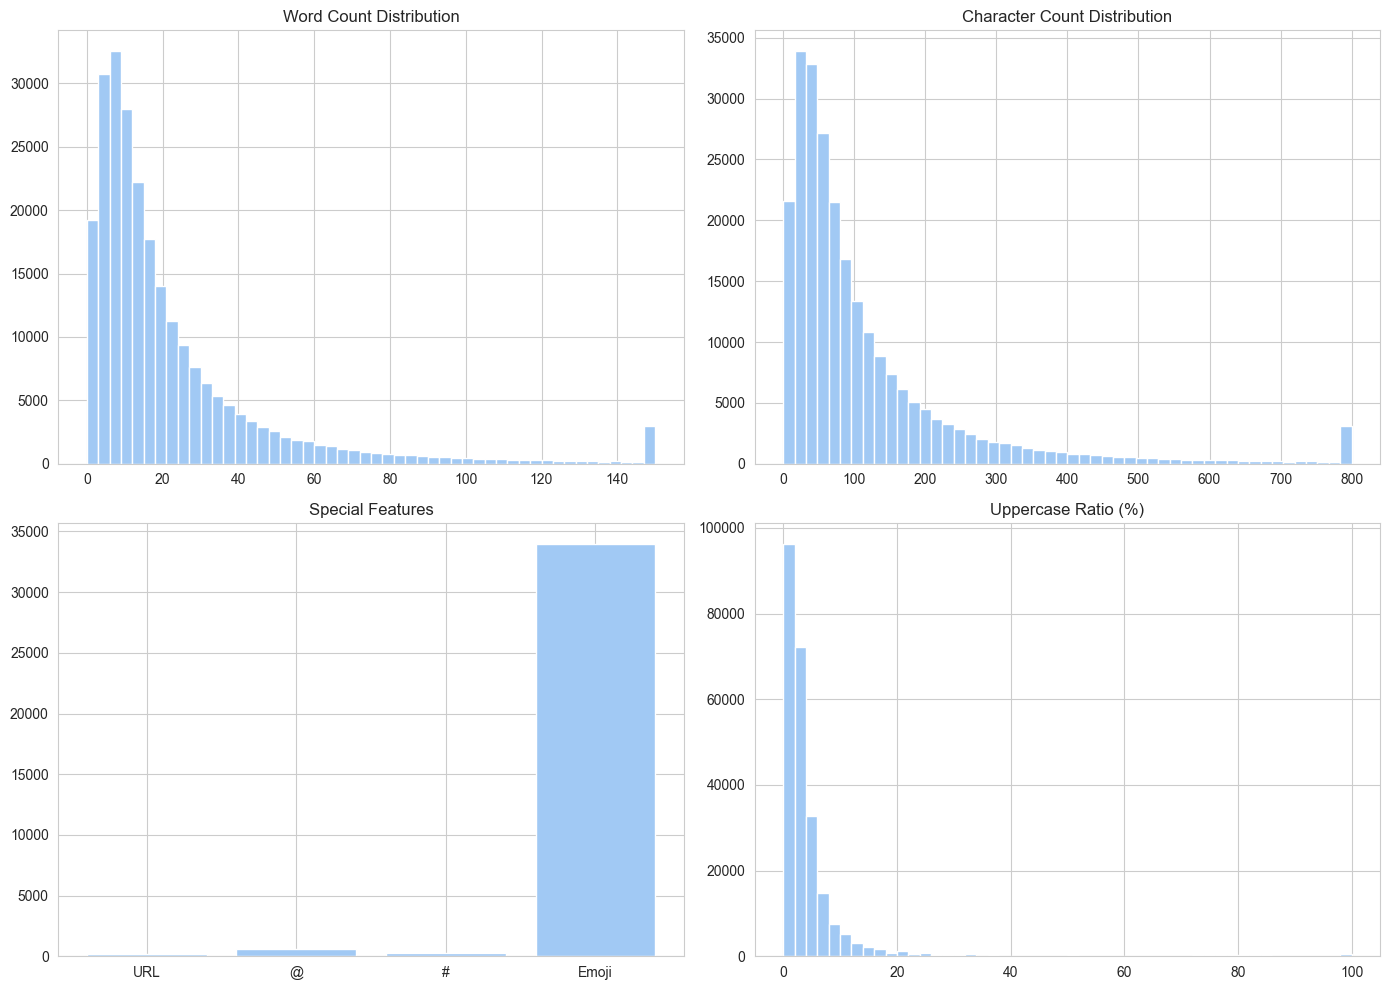

In [10]:
def plot_text_characteristic(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].hist(df["word_count"].clip(upper=150), bins=50)
    axes[0, 0].set_title("Word Count Distribution")

    axes[0, 1].hist(df["char_count"].clip(upper=800), bins=50)
    axes[0, 1].set_title("Character Count Distribution")

    features = [
        df["has_url"].sum(),
        df["has_mention"].sum(),
        df["has_hashtag"].sum(),
        (df["emoji_count"] > 0).sum(),
    ]

    axes[1, 0].bar(["URL", "@", "#", "Emoji"], features)
    axes[1, 0].set_title("Special Features")

    axes[1, 1].hist(df["uppercase_ratio"] * 100, bins=50)
    axes[1, 1].set_title("Uppercase Ratio (%)")

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "01_text_characteristic.png"), dpi=300)
    plt.show()

plot_text_characteristic(df)

#### 3.2 Time-based stats

In [11]:
df["day_of_week"] = df["comment_date"].dt.day_name()
df["hour"] = df["comment_date"].dt.hour
df["week"] = df["comment_date"].dt.to_period("W")
df["month"] = df["comment_date"].dt.to_period("M")

In [12]:
daily_comments = df.groupby(df["comment_date"].dt.date).size()

print("Peak day:", daily_comments.idxmax(), daily_comments.max())
print("Average per day:", daily_comments.mean())

Peak day: 2026-02-02 8317
Average per day: 2536.1649484536083


#### 3.3 Word Frequency Analysis

In [13]:
stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'is', 'are', 'was', 'were', 'been', 'be', 'have', 'has',
            'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'can',
            'this', 'that', 'these', 'those', 'it', 'its', 'i', 'you', 'he', 'she',
            'we', 'they', 'them', 'my', 'your', 'his', 'her', 'our', 'their', 'not',
            'just', 'get', 'got', 'like', 'so', 'really', 'even', 'one', 'know',
            'im', 'dont', 'thats', 'youre', 'cant', 'wont', 'isnt', 'arent'}

In [14]:
all_text = " ".join(df["text"].str.lower())
words = re.findall(r"\b[a-z]{3,}\b", all_text)
filtered_words = [w for w in words if w not in stopwords]

word_freq = Counter(filtered_words)

word_freq.most_common(20)

[('game', 55760),
 ('arc', 22612),
 ('all', 20363),
 ('people', 19047),
 ('pvp', 17487),
 ('what', 15946),
 ('more', 15817),
 ('out', 14830),
 ('when', 14636),
 ('raiders', 14627),
 ('don', 14522),
 ('play', 14219),
 ('there', 13448),
 ('only', 12968),
 ('about', 12928),
 ('good', 12883),
 ('from', 12571),
 ('time', 12161),
 ('how', 11596),
 ('games', 11056)]

#### 3.5 Looking at some comments

In [18]:
samples = df.sample(10)

for _, row in samples.iterrows():
    print("-"*80)
    print(row["video_title"])
    print(row["text"][:500])

--------------------------------------------------------------------------------
ARC Raiders - Nowy Update ROZCZAROWUJE? + Bany dla Cziterów...
Bany to powinny być dla graczy agresywnych co w friendly lobby zabijają innych. Kara to dołączenie 15-20 gier w PVP lobby, obecnie wystarczy zagrać 3-5 gier żeby system nas dodał do friendly, oczywiście nie jest to 100% friendly. Jeśli chcą się mieżyć PVP z innymi to niech pokażą jakie zabijaki są w PVP lobby co ludzie są nastawieni na strzelanke przez minimum 15-20 gier. Szanuje obie strony  PVP i PVE ale prawdziwy gracz PVP nie szuka darmowych zabójstw w PVE lobby jak to niektórzy potrafią....
--------------------------------------------------------------------------------
ARC Raiders - Angry Review
No facial hair is crazy!
--------------------------------------------------------------------------------
Arc Raiders is being destroyed
The industry knows they cant make games for shit so they need to tear down actually good games with bullshit t

In [16]:
comments_per_video = df.groupby("video_id").size()

print("Mean comments per video:", comments_per_video.mean())
print("Median comments per video:", comments_per_video.median())

Mean comments per video: 121.72587827808016
Median comments per video: 14.0
